# Aadhaar Pulse: Unlocking Trends, Update Burden, and Anomaly Signals

**Team ID:** UIDAI_12654  
**Project:** Aadhaar Pulse

## 1. Problem Statement and Approach

UIDAI has provided anonymised, aggregated datasets on Aadhaar enrolments and updates. The objective is to convert raw aggregated activity counts into actionable insights that can support operational decision-making. We propose a data-driven analytics framework consisting of EDA, Update Burden Index (UBI) KPI, Anomaly Detection, and Forecasting.

## 2. Dependencies and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from prophet import Prophet
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("viridis")

print("Libraries loaded.")

Libraries loaded.


## 3. Data Ingestion and Preprocessing

In [2]:
# Load Enrolment Data
enrol_files = sorted(glob("data/api_data_aadhar_enrolment/api_data_aadhar_enrolment_*.csv"))
enrol_df = pd.concat([pd.read_csv(f) for f in enrol_files], ignore_index=True)

# Load Demographic Updates
demo_files = sorted(glob("data/api_data_aadhar_demographic/api_data_aadhar_demographic_*.csv"))
demo_df = pd.concat([pd.read_csv(f) for f in demo_files], ignore_index=True)

# Load Biometric Updates
bio_files = sorted(glob("data/api_data_aadhar_biometric/api_data_aadhar_biometric_*.csv"))
bio_df = pd.concat([pd.read_csv(f) for f in bio_files], ignore_index=True)

# Date Parsing
for df in [enrol_df, demo_df, bio_df]:
    df["date"] = pd.to_datetime(df["date"], format="%d-%m-%Y")
    df["month"] = df["date"].dt.to_period("M").astype(str)

print(f"Enrolment Records: {len(enrol_df)}")
print(f"Demographic Updates: {len(demo_df)}")
print(f"Biometric Updates: {len(bio_df)}")

Enrolment Records: 1006029
Demographic Updates: 2071700
Biometric Updates: 1861108


## 4. Feature Engineering

Calculating total counts and the Update Burden Index (UBI).

In [3]:
# Totals
enrol_df["total_enrolments"] = enrol_df["age_0_5"] + enrol_df["age_5_17"] + enrol_df["age_18_greater"]
demo_df["total_demo_updates"] = demo_df["demo_age_5_17"] + demo_df["demo_age_17_"]
bio_df["total_bio_updates"] = bio_df["bio_age_5_17"] + bio_df["bio_age_17_"]

# Aggregations
monthly_enrol = enrol_df.groupby(["month", "state"])["total_enrolments"].sum().reset_index()
monthly_demo = demo_df.groupby(["month", "state"])["total_demo_updates"].sum().reset_index()
monthly_bio = bio_df.groupby(["month", "state"])["total_bio_updates"].sum().reset_index()

# Merge for UBI
ubi_df = monthly_enrol.merge(monthly_demo, on=["month", "state"], how="left")
ubi_df = ubi_df.merge(monthly_bio, on=["month", "state"], how="left")
ubi_df.fillna(0, inplace=True)

# UBI Calculation
ubi_df["total_updates"] = ubi_df["total_demo_updates"] + ubi_df["total_bio_updates"]
ubi_df["UBI"] = ubi_df["total_updates"] / (ubi_df["total_enrolments"] + 1)

print("Feature engineering complete.")

Feature engineering complete.


## 5. Data Analysis and Visualization

### 5.1 Dataset Overview
**Visualisation 1: Dataset Overview Bar Chart**

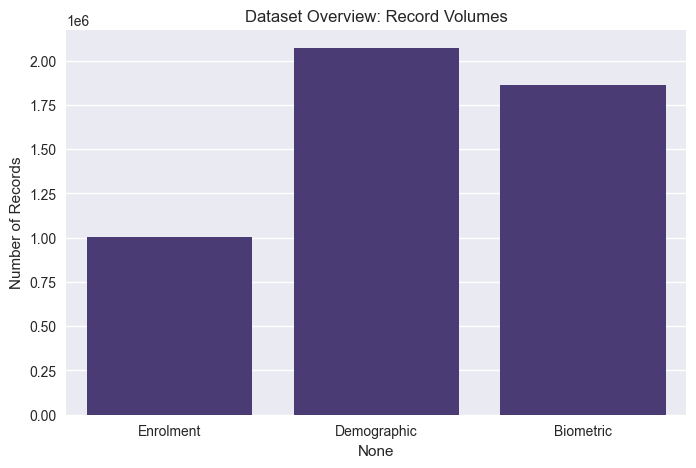

In [4]:
counts = pd.Series({
    "Enrolment": len(enrol_df),
    "Demographic": len(demo_df),
    "Biometric": len(bio_df)
})

plt.figure(figsize=(8, 5))
sns.barplot(x=counts.index, y=counts.values)
plt.title("Dataset Overview: Record Volumes")
plt.ylabel("Number of Records")
plt.show()

### 5.2 State-wise Enrolment Hotspots
**Visualisation 2: Top 10 States by Total Enrolments**

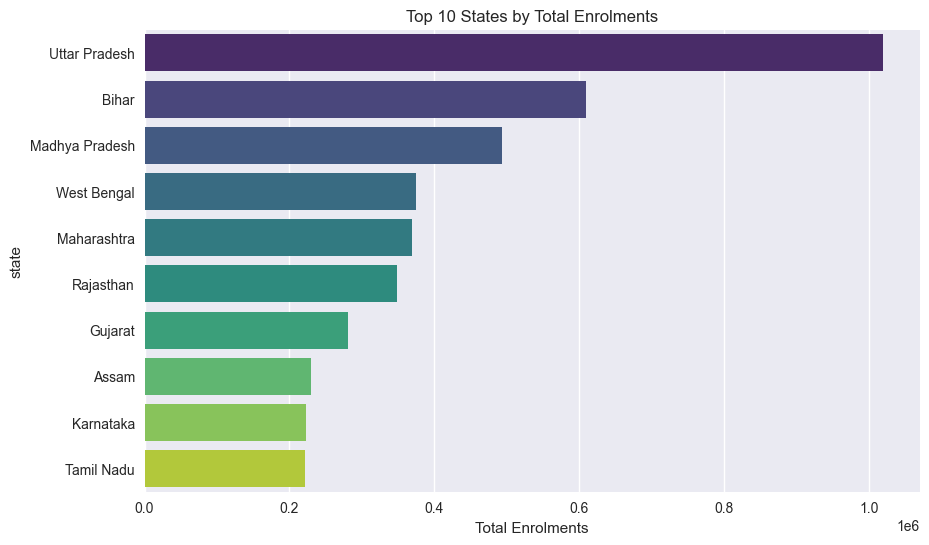

In [5]:
state_enrol = enrol_df.groupby("state")["total_enrolments"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=state_enrol.values, y=state_enrol.index, palette="viridis")
plt.title("Top 10 States by Total Enrolments")
plt.xlabel("Total Enrolments")
plt.show()

### 5.3 Age-wise Patterns
**Visualisation 3: Stacked Bar (State-wise Enrolments by Age Group)**

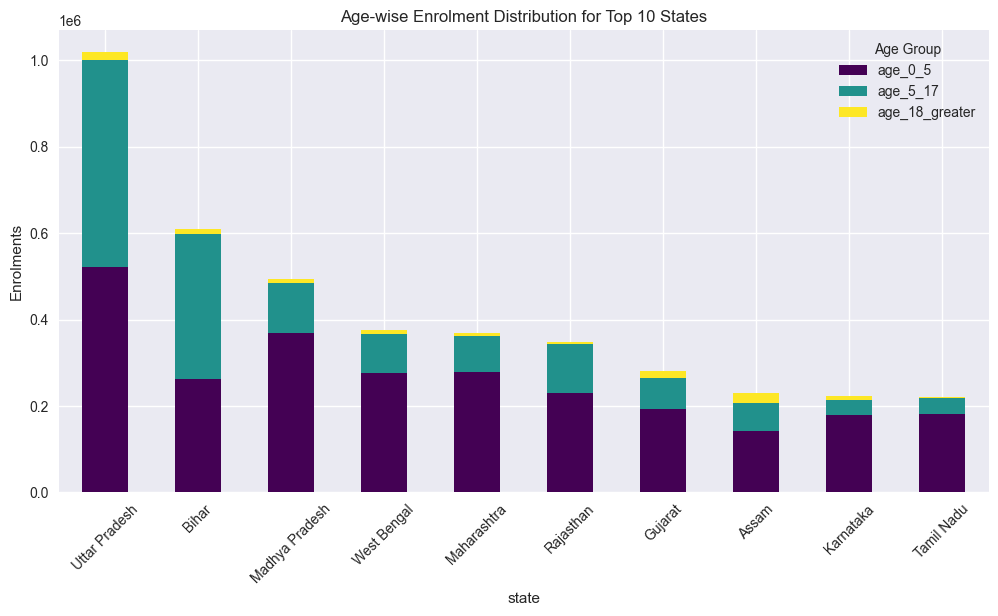

In [6]:
top_states = state_enrol.index
age_data = enrol_df[enrol_df["state"].isin(top_states)].groupby("state")[["age_0_5", "age_5_17", "age_18_greater"]].sum().loc[top_states]

age_data.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="viridis")
plt.title("Age-wise Enrolment Distribution for Top 10 States")
plt.ylabel("Enrolments")
plt.xticks(rotation=45)
plt.legend(title="Age Group")
plt.show()

**Visualisation 4: Monthly Trend of Enrolments by Age Group**

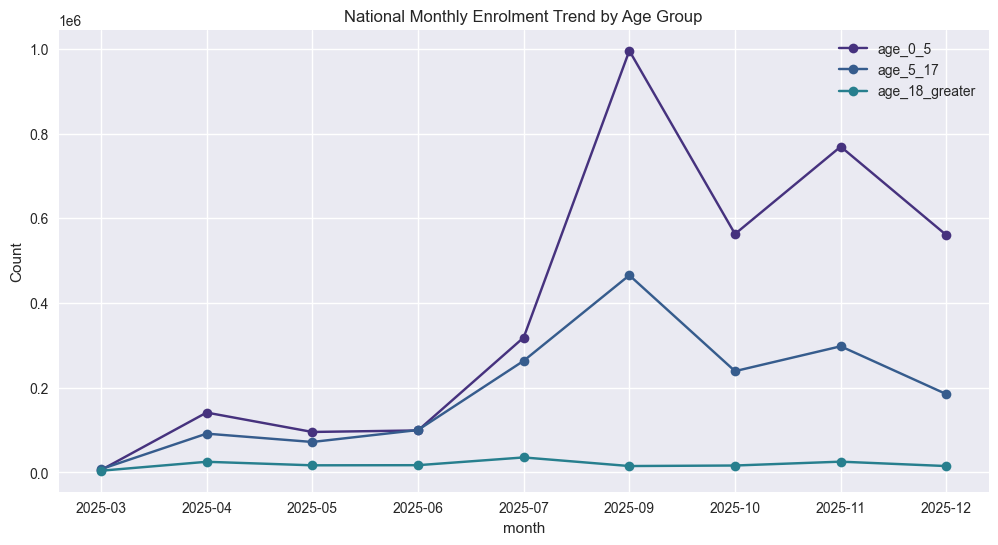

In [7]:
age_trend = enrol_df.groupby("month")[["age_0_5", "age_5_17", "age_18_greater"]].sum()

age_trend.plot(kind="line", figsize=(12, 6), marker="o")
plt.title("National Monthly Enrolment Trend by Age Group")
plt.ylabel("Count")
plt.grid(True)
plt.show()

### 5.4 Update Activity vs Enrolment
**Visualisation 5: Monthly Trend — Enrolments vs Total Updates**

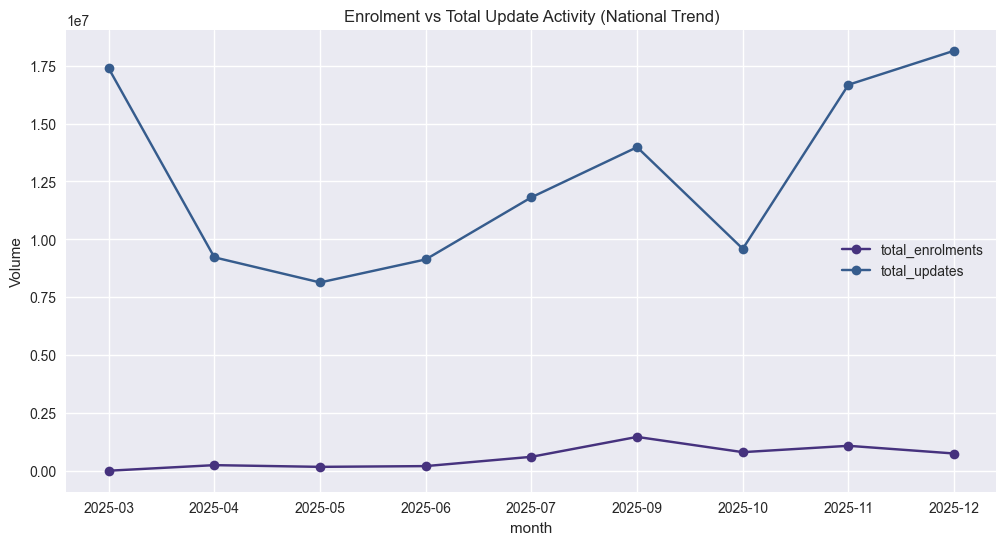

In [8]:
national_month = ubi_df.groupby("month")[["total_enrolments", "total_updates"]].sum()

national_month.plot(kind="line", figsize=(12, 6), marker="o", linestyle="-")
plt.title("Enrolment vs Total Update Activity (National Trend)")
plt.ylabel("Volume")
plt.show()

### 5.5 Update Burden Index (UBI)
**Visualisation 7: Top 10 States by UBI**
(Skipping Vis 6 for brevity/redundancy, focusing on UBI)

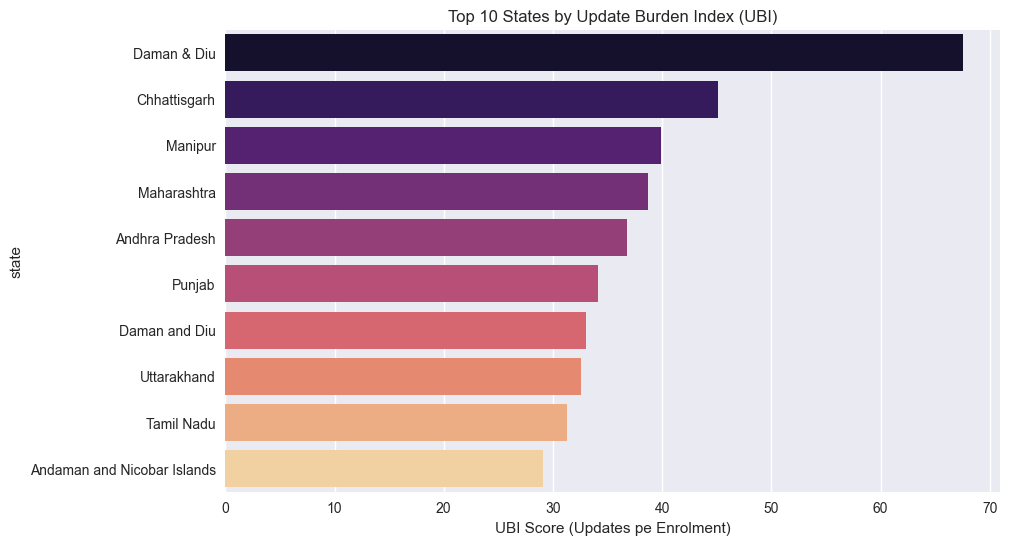

In [9]:
# Calculating weighted average UBI per state over the period
state_totals = ubi_df.groupby("state")[["total_updates", "total_enrolments"]].sum()
state_totals["UBI"] = state_totals["total_updates"] / (state_totals["total_enrolments"] + 1)

top_ubi = state_totals["UBI"].sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_ubi.values, y=top_ubi.index, palette="magma")
plt.title("Top 10 States by Update Burden Index (UBI)")
plt.xlabel("UBI Score (Updates pe Enrolment)")
plt.show()

**Visualisation 8: UBI Trend Over Time**

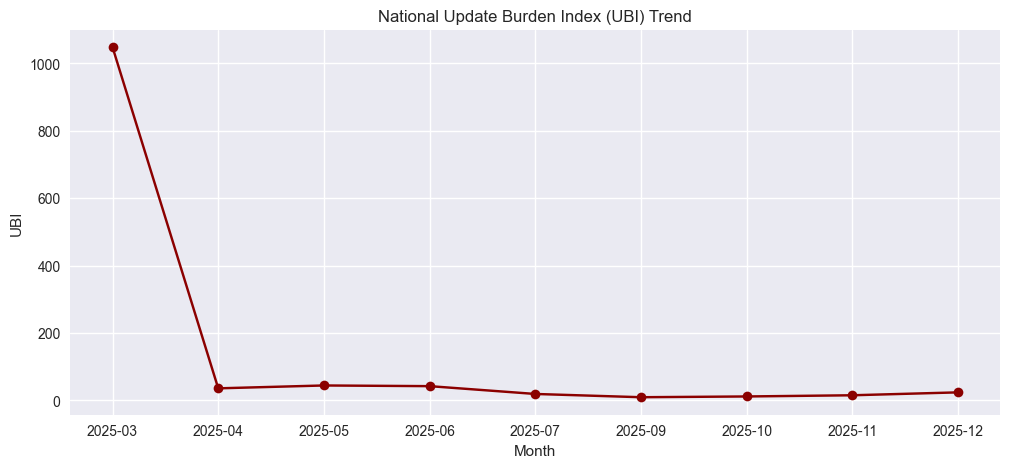

In [10]:
# National UBI Trend
national_ubi = ubi_df.groupby("month")[["total_updates", "total_enrolments"]].sum()
national_ubi["UBI"] = national_ubi["total_updates"] / (national_ubi["total_enrolments"] + 1)

plt.figure(figsize=(12, 5))
plt.plot(national_ubi.index.astype(str), national_ubi["UBI"], marker="o", color="darkred")
plt.title("National Update Burden Index (UBI) Trend")
plt.xlabel("Month")
plt.ylabel("UBI")
plt.grid(True)
plt.show()

## 6. Anomaly Detection
**Visualisation 9: Anomaly Marker Plot**

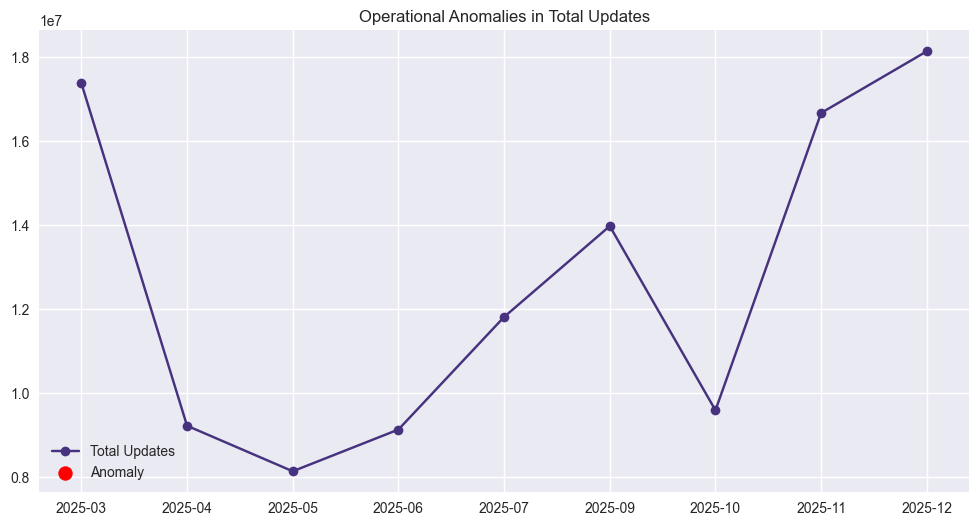

Detected Anomalies:
Empty DataFrame
Columns: [month, value, z_score]
Index: []


In [11]:
anomaly_df = national_month.copy().reset_index()
anomaly_df["value"] = anomaly_df["total_updates"]
window = 3
anomaly_df["roll_mean"] = anomaly_df["value"].rolling(window).mean()
anomaly_df["roll_std"] = anomaly_df["value"].rolling(window).std()
anomaly_df["z_score"] = (anomaly_df["value"] - anomaly_df["roll_mean"]) / (anomaly_df["roll_std"] + 1e-6)
anomaly_df["is_anomaly"] = anomaly_df["z_score"].abs() > 2  # Lower threshold for visual example

plt.figure(figsize=(12, 6))
plt.plot(anomaly_df["month"], anomaly_df["value"], label="Total Updates", marker="o")

anomalies = anomaly_df[anomaly_df["is_anomaly"]]
plt.scatter(anomalies["month"], anomalies["value"], color="red", s=100, label="Anomaly", zorder=5)

plt.title("Operational Anomalies in Total Updates")
plt.legend()
plt.show()

print("Detected Anomalies:")
print(anomalies[["month", "value", "z_score"]])

## 7. Forecasting
**Visualisation 10 & 11: Forecast for Updates**

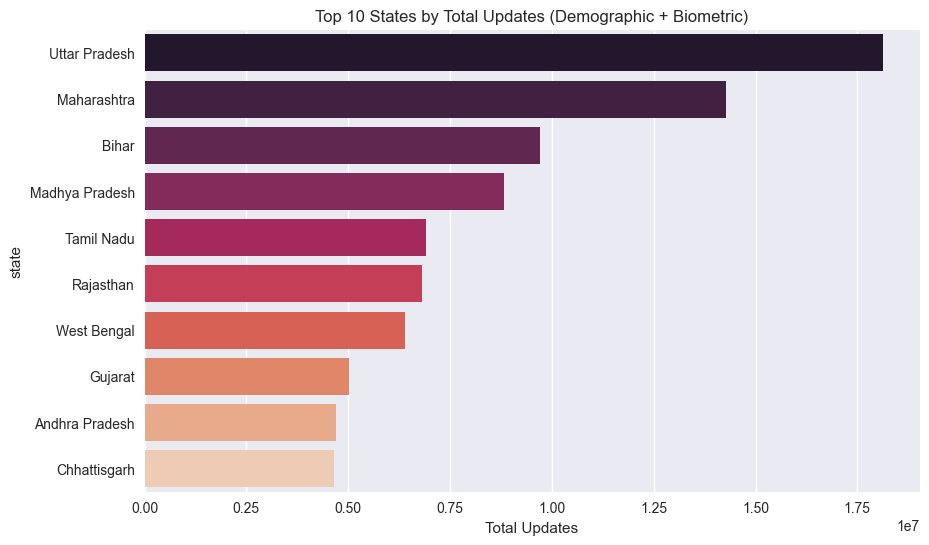

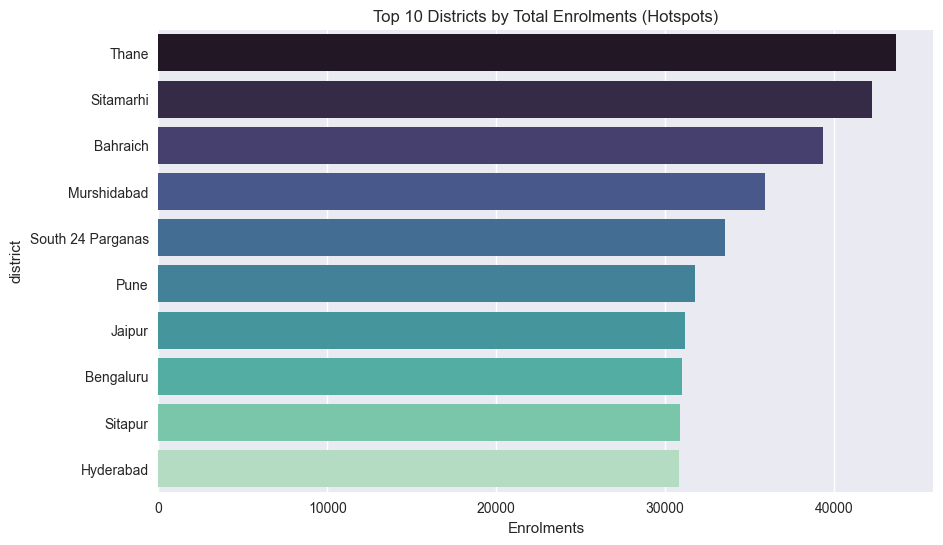

In [12]:

# --- NEW ANALYSES ---

### 5.6 Top 10 States by Total Updates
# **Visualisation 6B: Top 10 States by Update Activity** 
state_updates = ubi_df.groupby("state")["total_updates"].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=state_updates.values, y=state_updates.index, palette="rocket")
plt.title("Top 10 States by Total Updates (Demographic + Biometric)")
plt.xlabel("Total Updates")
plt.show()

### 5.7 District Drill-Down
# **Visualisation 10: Top 10 Districts by Enrolment**
dist_enrol = enrol_df.groupby("district")["total_enrolments"].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=dist_enrol.values, y=dist_enrol.index, palette="mako")
plt.title("Top 10 Districts by Total Enrolments (Hotspots)")
plt.xlabel("Enrolments")
plt.show()

20:07:48 - cmdstanpy - INFO - Chain [1] start processing
20:07:48 - cmdstanpy - INFO - Chain [1] done processing


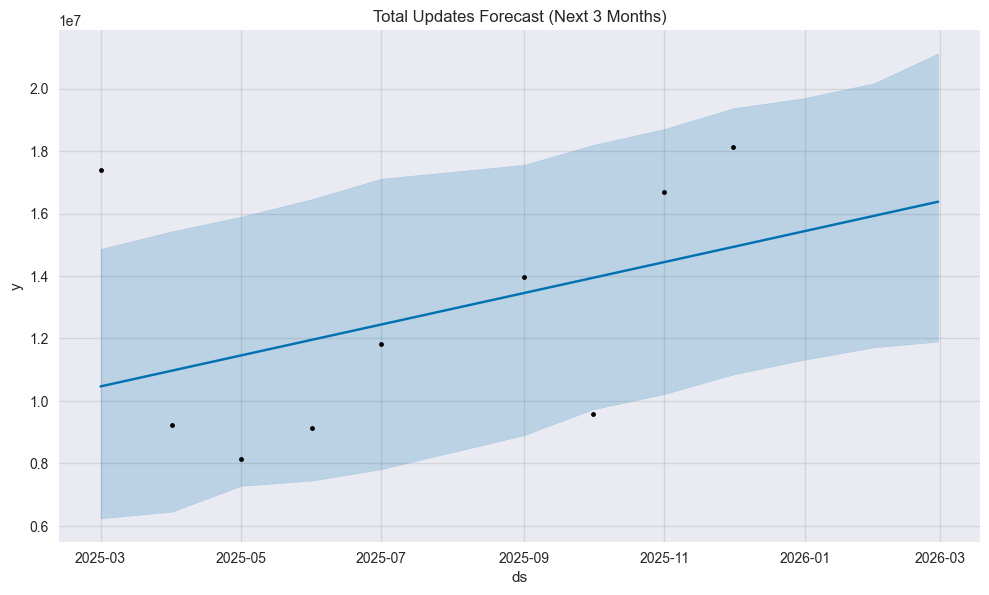

           ds          yhat    yhat_lower    yhat_upper
9  2025-12-31  1.541950e+07  1.130524e+07  1.968438e+07
10 2026-01-31  1.592309e+07  1.171368e+07  2.016876e+07
11 2026-02-28  1.637795e+07  1.189864e+07  2.112494e+07


In [13]:
df_forecast = national_month.reset_index()[["month", "total_updates"]].rename(columns={"total_updates": "y"})
df_forecast["ds"] = pd.to_datetime(df_forecast["month"] + "-01")

m = Prophet()
m.fit(df_forecast)
future = m.make_future_dataframe(periods=3, freq="M")
forecast = m.predict(future)

m.plot(forecast)
plt.title("Total Updates Forecast (Next 3 Months)")
plt.show()

print(forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(3))

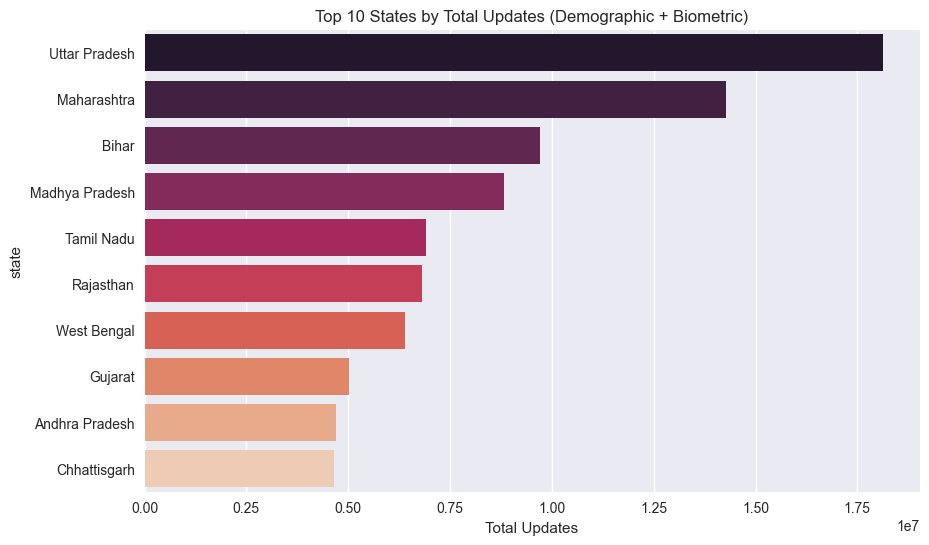

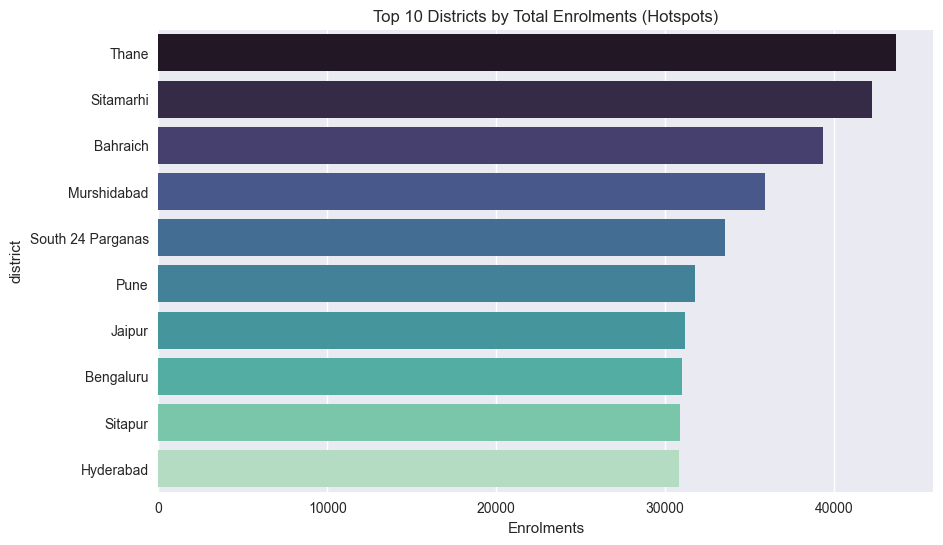

In [14]:

# --- NEW ANALYSES ---

# ### 5.6 Top 10 States by Total Updates
# **Visualisation 6B: Top 10 States by Update Activity** 
state_updates = ubi_df.groupby("state")["total_updates"].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=state_updates.values, y=state_updates.index, palette="rocket")
plt.title("Top 10 States by Total Updates (Demographic + Biometric)")
plt.xlabel("Total Updates")
plt.show()

# ### 5.7 District Drill-Down
# **Visualisation 10: Top 10 Districts by Enrolment**
dist_enrol = enrol_df.groupby("district")["total_enrolments"].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=dist_enrol.values, y=dist_enrol.index, palette="mako")
plt.title("Top 10 Districts by Total Enrolments (Hotspots)")
plt.xlabel("Enrolments")
plt.show()